## Examples using KNearestNeighborsClassifier

### Import Libraries

In [45]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_blobs
from imblearn.over_sampling import SMOTE, ADASYN 
import fastkde
from KNearestNeighborsClassifier import KNearestNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [2]:
seed = int('dada441', 16) # For setting random states

### Application on Randomly Generated Dataset

In [37]:
# Generate data
centers = [(-1, -1), (1, 1)]
cluster_std = [0.7, 1]

X, y = make_blobs(n_samples=200, random_state=seed)
(X.shape, y.shape)

((200, 2), (200,))

In [45]:
split = 160
Xtrain = torch.tensor(X[:split])
Xtest = torch.tensor(X[split:])
ytrain = torch.tensor(y[:split])
ytest = torch.tensor(y[split:])

knnc = KNearestNeighborsClassifier()
knnc.fit(Xtrain, ytrain)
y_preds = knnc.predict(Xtest)

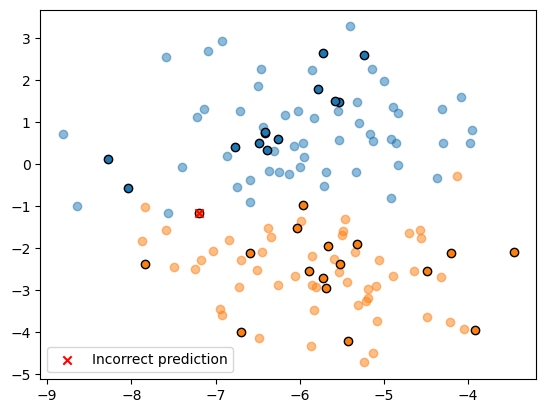

In [70]:
colors = ['tab:blue', 'tab:orange']

for label in (0,1):
    plt.scatter(Xtrain[:,0][ytrain == label], Xtrain[:,1][ytrain == label], color=colors[label], alpha=0.5) # Training data (alpha=0.5)
    plt.scatter(Xtest[:,0][y_preds == label], Xtest[:,1][y_preds == label], color=colors[label], ec='black') # Testing data and prediction (alpha=1)
plt.scatter(Xtest[:,0][ytest != y_preds], Xtest[:,1][ytest != y_preds], marker='x', color='red', label='Incorrect prediction') # marker='x'
plt.legend()
plt.show()

### Hyperparameter Tuning on Randomly Generated Dataset with Class Imbalance

#### 

In [3]:
# Generate data with class imbalance
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=seed)

print(X.shape, y.shape)

(10000, 2) (10000,)


In [72]:
print("Number of 0's:", len(y[y == 0]))
print("Number of 1's:", len(y[y == 1]))

Number of 0's: 9900
Number of 1's: 100


In [4]:
def plot_data(X, y, labels = [0,1], alpha = 0.5):
    for y_val in labels:
        plt.scatter(X[:,0][y == y_val], X[:,1][y == y_val], alpha = alpha, label = y_val)
    plt.legend()
    plt.show()

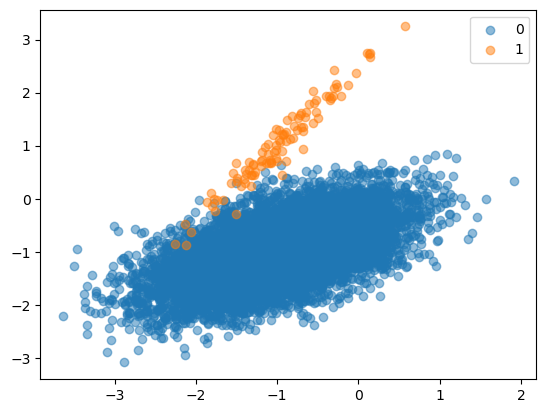

In [74]:
plot_data(X, y)

In [14]:
def DoKFold(X:np.array, y:np.array, model, labels = [0,1], n_splits = 5):
    '''
    Perform stratified k-fold validation.

    Args:
        X: Sample data
        y: Target values/labels
        model: Model to fit and predict with
        labels: Unique labels; determines the order in which precision and recall scores are output
        n_splits: Number of splits for the stratified k-fold validation

    Returns:
        int: The average proportion of correct predictions
        numpy.ndarray: Average precision scores for each target value
        numpy.ndarray: Average recall scores for each target value
    '''
    accuracy = []
    precision = []
    recall = []

    skf = StratifiedKFold(n_splits=n_splits)
    for idx_train, idx_test in skf.split(X, y):
        Xtrain = X[idx_train]
        Xtest = X[idx_test]
        ytrain = y[idx_train]
        ytest = y[idx_test]

        model.fit(Xtrain, ytrain)
        y_pred = model.predict(Xtest)

        accuracy.append(sum(ytest == y_pred) / len(ytest))
        results = precision_recall_fscore_support(ytest, y_pred, labels = labels)
        precision.append(results[0])
        recall.append(results[1])
    
    # Return average precision and recall scores for each target value
    return np.mean(accuracy), np.mean(precision, axis=0), np.mean(recall, axis=0)

In [33]:
# accuracy, [precision for y=0, precision for y=1], [recall for y=0, precision for y=1]
DoKFold(X, y, KNearestNeighborsClassifier()) 

(0.9983000000000001,
 array([0.99879042, 0.94502924]),
 array([0.99949495, 0.88      ]))

In [15]:
def try_n_neighbors(n_neighbors_list:list, X:torch.Tensor, y:torch.Tensor, labels = [0,1], n_splits = 5):
    '''
    Perform stratified k-fold validation for each n_neighbors hyperparameter value in n_neighbors list.

    Args:
        n_neighbors_list: List of n_neighbors to try
        X: Sample data
        y: Target values/labels
        labels: Unique labels
        n_splits: Number of splits for the stratified k-fold validation 
    '''
    precision_scores = []
    recall_scores = []
    for n in n_neighbors_list:
        print("Performing stratified k-fold validation with n_neighbors =", n)
        accuracy, precision, recall = DoKFold(X, y, KNearestNeighborsClassifier(n_neighbors=n), labels=labels, n_splits=n_splits) 
                
        # Print results
        print("\t", end = "")
        for label in [0,1]:
            print(f"\t{label}", end = "")
        print("\nPrecision\t", end = "")
        for p in precision:
            print(f"{round(p, 5)}\t", end = "")
        print("\nRecall\t\t", end = "")
        for r in recall:
            print(f"{round(r, 5)}\t", end = "")
        print("\nOverall accuracy:", accuracy)

In [37]:
n_neighbors_list = np.arange(3, 22, 2)
try_n_neighbors(n_neighbors_list, X, y, n_splits=10)

Performing stratified k-fold validation with n_neighbors = 3
		0	1
Precision	0.99889	0.94265	
Recall		0.99939	0.89	
Overall accuracy: 0.9982999999999999
Performing stratified k-fold validation with n_neighbors = 5
		0	1
Precision	0.99889	0.95023	
Recall		0.99949	0.89	
Overall accuracy: 0.9984
Performing stratified k-fold validation with n_neighbors = 7
		0	1
Precision	0.99899	0.95023	
Recall		0.99949	0.9	
Overall accuracy: 0.9984999999999999
Performing stratified k-fold validation with n_neighbors = 9
		0	1
Precision	0.99879	0.94844	
Recall		0.99949	0.88	
Overall accuracy: 0.9982999999999999
Performing stratified k-fold validation with n_neighbors = 11
		0	1
Precision	0.99869	0.96273	
Recall		0.9996	0.87	
Overall accuracy: 0.9983000000000001
Performing stratified k-fold validation with n_neighbors = 13
		0	1
Precision	0.99859	0.95273	
Recall		0.99949	0.86	
Overall accuracy: 0.9981
Performing stratified k-fold validation with n_neighbors = 15
		0	1
Precision	0.99849	0.97182	
Recall		0.9

In [48]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=seed)

model = KNearestNeighborsClassifier(n_neighbors=7)
model.fit(Xtrain, ytrain)
y_pred = model.predict(Xtest)
print(classification_report(ytest, y_pred))
print("Proportion of correct predictions:", sum(ytest == y_pred) / len(ytest))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1981
           1       0.89      0.84      0.86        19

    accuracy                           1.00      2000
   macro avg       0.94      0.92      0.93      2000
weighted avg       1.00      1.00      1.00      2000

Proportion of correct predictions: 0.9975


#### Synthetic Minority Oversampling Technique (SMOTE)

Number of samples: 29800
Number of 0's: 19800
Number of 1's: 10000


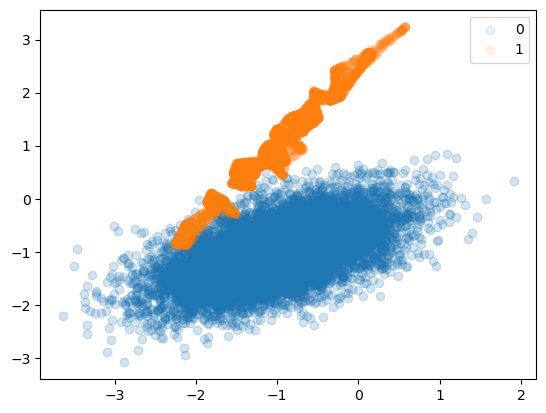

In [25]:
smote = SMOTE(random_state = seed)
X_smote, y_smote = smote.fit_resample(X, y)

X_smote = np.row_stack([X, X_smote])
y_smote = np.concatenate([y, y_smote])

print("Number of samples:", len(y_smote))
print("Number of 0's:", len(y_smote[y_smote == 0]))
print("Number of 1's:", len(y_smote[y_smote == 1]))
plot_data(X_smote, y_smote, alpha=0.1)

In [26]:
try_n_neighbors(n_neighbors_list, X_smote, y_smote, n_splits=10)

Performing stratified k-fold validation with n_neighbors = 3
		0	1
Precision	0.99767	0.99193	
Recall		0.99591	0.9954	
Overall accuracy: 0.9957382550335572
Performing stratified k-fold validation with n_neighbors = 5
		0	1
Precision	0.99909	0.99146	
Recall		0.99566	0.9982	
Overall accuracy: 0.9965100671140942
Performing stratified k-fold validation with n_neighbors = 7
		0	1
Precision	0.99893	0.98881	
Recall		0.99429	0.9979	
Overall accuracy: 0.995503355704698
Performing stratified k-fold validation with n_neighbors = 9
		0	1
Precision	0.99959	0.98805	
Recall		0.99389	0.9992	
Overall accuracy: 0.9956711409395973
Performing stratified k-fold validation with n_neighbors = 11
		0	1
Precision	0.99954	0.98785	
Recall		0.99379	0.9991	
Overall accuracy: 0.9955704697986576
Performing stratified k-fold validation with n_neighbors = 13
		0	1
Precision	0.9999	0.98766	
Recall		0.99369	0.9998	
Overall accuracy: 0.995738255033557
Performing stratified k-fold validation with n_neighbors = 15
		0	1
Pre

In [40]:
model = KNearestNeighborsClassifier(n_neighbors=5)
model.fit(X_smote, y_smote) # Train with oversampled data
y_pred = model.predict(X) # Predict with original data
print(classification_report(y, y_pred))
print("Overall accuracy:", sum(y == y_pred) / len(y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9900
           1       0.72      1.00      0.84       100

    accuracy                           1.00     10000
   macro avg       0.86      1.00      0.92     10000
weighted avg       1.00      1.00      1.00     10000

Overall accuracy: 0.9961


#### Adaptive Synthetic (ADASYN) Oversampling

Number of samples: 29804
Number of 0's: 19800
Number of 1's: 10004


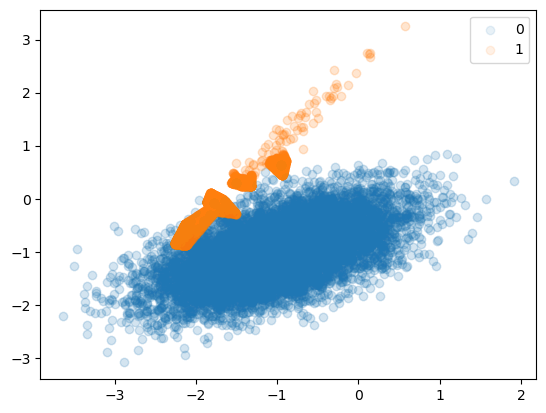

In [27]:
adasyn = ADASYN(random_state = seed)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

X_adasyn = np.row_stack([X, X_adasyn])
y_adasyn = np.concatenate([y, y_adasyn])

print("Number of samples:", len(X_adasyn))
print("Number of 0's:", len(y_adasyn[y_adasyn == 0]))
print("Number of 1's:", len(y_adasyn[y_adasyn == 1]))
plot_data(X_adasyn, y_adasyn, alpha=0.1)

In [28]:
try_n_neighbors(n_neighbors_list, X_adasyn, y_adasyn, n_splits=10)

Performing stratified k-fold validation with n_neighbors = 3
		0	1
Precision	0.97413	0.98946	
Recall		0.9952	0.9358	
Overall accuracy: 0.9752691768223357
Performing stratified k-fold validation with n_neighbors = 5
		0	1
Precision	0.97547	0.98916	
Recall		0.99505	0.9381	
Overall accuracy: 0.9759401939351914
Performing stratified k-fold validation with n_neighbors = 7
		0	1
Precision	0.97537	0.98565	
Recall		0.99359	0.938	
Overall accuracy: 0.974933583838584
Performing stratified k-fold validation with n_neighbors = 9
		0	1
Precision	0.97755	0.98592	
Recall		0.99359	0.9437	
Overall accuracy: 0.9768463130024833
Performing stratified k-fold validation with n_neighbors = 11
		0	1
Precision	0.97758	0.98587	
Recall		0.99354	0.9441	
Overall accuracy: 0.976946984143423
Performing stratified k-fold validation with n_neighbors = 13
		0	1
Precision	0.97811	0.98554	
Recall		0.99333	0.9455	
Overall accuracy: 0.9772825771271745
Performing stratified k-fold validation with n_neighbors = 15
		0	1
Prec

In [41]:
model = KNearestNeighborsClassifier(n_neighbors=21)
model.fit(X_adasyn, y_adasyn)
y_pred = model.predict(X)
print(classification_report(y, y_pred))
print("Overall accuracy:", sum(y == y_pred) / len(y))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      9900
           1       0.57      1.00      0.72       100

    accuracy                           0.99     10000
   macro avg       0.78      1.00      0.86     10000
weighted avg       1.00      0.99      0.99     10000

Overall accuracy: 0.9924


#### Fast KDE with Uniform Sampling

Number of samples: 11500
Number of 0's: 9900
Number of 1's: 1600


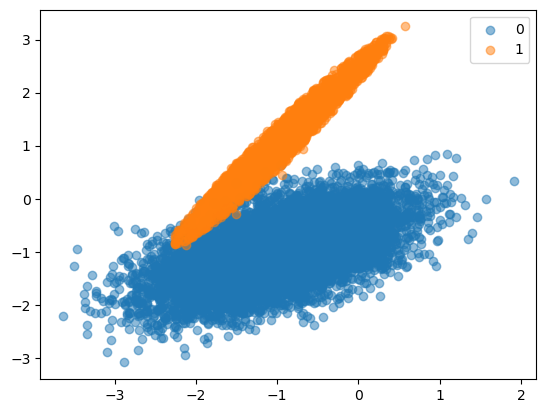

In [34]:
# Get lower and upper bounds of each minority feature (target value is 1)
minority_features = X[y == 1]
lower_bounds = minority_features.min(axis=0) # Compute the minimum of each column
upper_bounds = minority_features.max(axis=0) # Maximum

# Generate data between the bounds
np.random.seed(seed)
list_of_points = np.random.uniform(low=lower_bounds, high=upper_bounds, size=(10000,2))
# Estimate density estimates of the data
pdf = fastkde.pdf_at_points(minority_features[:,0], minority_features[:,1], list_of_points=list_of_points)
X_fastkde = list_of_points[pdf > np.percentile(pdf,85)] # Exclude "badly" generated data
y_fastkde = np.ones(len(X_fastkde))

X_fastkde = np.row_stack([X, X_fastkde])
y_fastkde = np.concatenate([y, y_fastkde])

print("Number of samples:", len(X_fastkde))
print("Number of 0's:", len(y_fastkde[y_fastkde == 0]))
print("Number of 1's:", len(y_fastkde[y_fastkde == 1]))
plot_data(X_fastkde, y_fastkde)

In [42]:
try_n_neighbors(n_neighbors_list, X_fastkde, y_fastkde, n_splits=10)

Performing stratified k-fold validation with n_neighbors = 3
		0	1
Precision	0.99707	0.96395	
Recall		0.99404	0.98188	
Overall accuracy: 0.9923478260869565
Performing stratified k-fold validation with n_neighbors = 5
		0	1
Precision	0.99777	0.96111	
Recall		0.99354	0.98625	
Overall accuracy: 0.9925217391304347
Performing stratified k-fold validation with n_neighbors = 7
		0	1
Precision	0.99848	0.9602	
Recall		0.99333	0.99062	
Overall accuracy: 0.9929565217391303
Performing stratified k-fold validation with n_neighbors = 9
		0	1
Precision	0.99868	0.9585	
Recall		0.99303	0.99188	
Overall accuracy: 0.9928695652173914
Performing stratified k-fold validation with n_neighbors = 11
		0	1
Precision	0.99848	0.95613	
Recall		0.99263	0.99062	
Overall accuracy: 0.9923478260869565
Performing stratified k-fold validation with n_neighbors = 13
		0	1
Precision	0.99828	0.96006	
Recall		0.99333	0.98937	
Overall accuracy: 0.9927826086956522
Performing stratified k-fold validation with n_neighbors = 15
		

In [43]:
model = KNearestNeighborsClassifier(n_neighbors=17)
model.fit(X_fastkde, y_fastkde)
y_pred = model.predict(X)
print(classification_report(y, y_pred))
print("Overall accuracy:", sum(y == y_pred) / len(y))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      9900
           1       0.59      0.97      0.73       100

    accuracy                           0.99     10000
   macro avg       0.80      0.98      0.87     10000
weighted avg       1.00      0.99      0.99     10000

Overall accuracy: 0.993
